# Finding the Diabetes Belt
### Building a Binary Classifier using the USDA's Food Atlas

# Table of Contents

* Introduction
* Obtain
* Scrub
* Explore
    * Correlation
    * Feature Ranking
* Model
* Interpret
    * Conclusion

# Introduction

In this project, I will be examining diabetes rates in US counties, and will attempt to **build a classifier that will predict whether a particular county will have an adult diabetes rate above or below 11%.**

In 2011, the CDC identified a cluster of counties in the Southeastern United States where the diabetes rate was substantially higher than the national average. In order to raise awareness, they classified any county with an adult diabetes rate of 11% or more as part of a **“Diabetes Belt."**

The CDC based their designation off of data recorded back in 2008, and the epidemic of diabetes has only gotten worse over the years. We have access to public county level data on diabetes as recent as 2013. Based on other health measures, **can we predict which counties would be a part of the diabetes belt in 2013?**

The USDA’s Food Environment Atlas contains county level data on a wide variety of factors related to food access, health, and socioeconomics. As I hypothesize that there will be relationships between diabetes and some of these other measures, I will attempt to use this data to build my classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import reduce
from collections import defaultdict

%matplotlib inline

# Obtain

First, we'll load in the data. This may be located at the following address:

https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/

The data is in an excel spreadsheet, with the various features separated by category across multiple sheets. Fortunately, all of these sheets share a "FIPS" code column, which makes it easy to load into dataframes and then combine.

In [2]:
def read(file):
    excel = pd.ExcelFile(file)
    sheets = excel.sheet_names[4:]

    dataframes = [excel.parse(sheet_name=sheet) for sheet in sheets]

    df = reduce(lambda left,right: pd.merge(left,right,on='FIPS'), dataframes)

    return df

In [3]:
data = read('food_atlas.xls')
data.shape

(3143, 296)

In [4]:
data.head()

,FIPS,State_x,County_x,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0
1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,0.043343,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,0.087409,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0
3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,...,0.030548,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0
4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,...,0.031402,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0


# Scrub

As we can see, there are an awful lot of features here! We need to narrow this down. To do this, we'll use the following process:

1. The only text features are the **State and County** names. These can be dropped.
2. For each feature in raw count format, there is a corresponding column that displays the feature normalized by population. This means we can **drop all of the raw counts**, as it is the normalized version we want.
3. Some measurements were taken in multiple years. Since we are trying to predict diabetes risk in 2013, **we don't want to use any measurements taken after 2013**. We also only want to use the **most recent measurement taken during or prior to 2013.**
4. Some features show the **difference between measurements from year to year**. These would be useful for other experiments, but **not for ours**.
5. Finally, **if a feature has null values, we'll drop the column**. Because each row is a county, if we aren't this strict, we'll lose valuable data on diabetes rates.

In [5]:
def clean(df):
    
    to_remove = []
    
    # load variable names
    variables = pd.read_excel('food_atlas.xls', sheet_name=1)
    
    # keep only numerical features
    df = df.select_dtypes(include=['float64', 'int64'])
    
    columns = set(df.columns)
    
    # select all raw counts for removal
    raw_counts = set(variables.loc[variables.Units.isin(['Count', 'Dollars', 'Acres', 'Sq ft']), 'Variable Code'])
    columns = columns - raw_counts
    
    # select all measurements after 2013 for removal
    future = ["14", "15", "16"]
    in_future = []
    col_series = pd.Series(list(columns))
    for year in future:
        in_future += list(col_series[col_series.str.endswith(year)])
    in_future = set(in_future)

    columns = columns - in_future
    
    # remove all time interval change measures
    col_series = pd.Series(list(columns))
    time_change = col_series[col_series.str.contains("_[01][0123456678]_[01][0123456678]")]
    time_change = set(list(time_change))
    columns = columns - time_change
    
    # select all older remaining duplicate measurements for removal
    old_measures = []
    digits = '0123456789'
    mydict = defaultdict(list) 
    col_list = list(columns)
    for column in sorted(col_list):
        c = column
        for digit in digits:
            c = c.replace(digit, "")
        key = c.replace("_", "")
        mydict[key].append(column)
    
    for k, v in mydict.items():
        if len(v) > 1:
            old_measures.append(v[0])
    
    old_measures = set(old_measures)
    columns = columns - old_measures
    
    df = df[list(columns)]
    
    # drop rows with missing values
    df = df.dropna(axis=0, subset=['PCT_DIABETES_ADULTS13'])
    df = df.dropna(axis=1)
    
    return df

In [6]:
df = clean(data)

In [7]:
fips = df.pop('FIPS')
df.shape

(3142, 37)

In [8]:
df.head()

,METRO13,CONVSPTH09,GROCPTH09,PERCHLDPOV10,PERPOV10,PCT_SNAP12,PCT_HISP10,PCT_LACCESS_SENIORS10,PCT_SBP09,PCT_LACCESS_POP10,...,PCT_WIC09,PCT_65OLDER10,PCT_CACFP09,SNAP_CAP09,PCT_SFSP09,WICSPTH12,PCT_NSLP09,SNAP_OAPP09,SNAP_PART_RATE13,PCT_NHPI10
0,1,0.535698,0.110834,0,0,18.824675,2.400542,4.376378,4.509008,33.769657,...,2.990417,11.995382,0.91609,0,0.56489,0.090067,12.315055,0.0,89.184,0.040314
1,1,0.663300,0.133775,0,0,18.824675,4.384824,3.513570,4.509008,19.318473,...,2.990417,16.771185,0.91609,0,0.56489,0.141517,12.315055,0.0,89.184,0.043343
2,0,0.506201,0.180786,1,1,18.824675,5.051535,2.805166,4.509008,20.840972,...,2.990417,14.236807,0.91609,0,0.56489,0.257344,12.315055,0.0,89.184,0.087409
3,1,0.828211,0.261540,1,0,18.824675,1.771765,0.657008,4.509008,4.559753,...,2.990417,12.681650,0.91609,0,0.56489,0.221268,12.315055,0.0,89.184,0.030548
4,1,0.540625,0.104637,0,0,18.824675,8.070200,0.340269,4.509008,2.700840,...,2.990417,14.722096,0.91609,0,0.56489,0.103760,12.315055,0.0,89.184,0.031402


# Explore

We've reduced the dataset substantially, and still have plenty to work with! Let's write a function that will tell us what these are.

In [9]:
def decode(features):
    variables = pd.read_excel('food_atlas.xls', sheet_name=1)
    columns = ['Variable Code', 'Variable Name', 'Category Name', 'Subcategory Name', 'Units']
    if type(features) == list:
        return variables.loc[variables['Variable Code'].isin(features), columns]
    else:
        return variables[variables['Variable Code'] == features, columns]

In [10]:
decoded_features = decode(list(df.columns))
decoded_features

,Variable Code,Variable Name,Category Name,Subcategory Name,Units
3,PCT_LACCESS_POP10,"Population, low access to store (%), 2010",Access and Proximity to Grocery Store,Overall,Percent
8,PCT_LACCESS_LOWI10,"Low income & low access to store (%), 2010",Access and Proximity to Grocery Store,Household Resources,Percent
13,PCT_LACCESS_HHNV10,"Households, no car & low access to store (%), ...",Access and Proximity to Grocery Store,Household Resources,Percent
20,PCT_LACCESS_CHILD10,"Children, low access to store (%), 2010",Access and Proximity to Grocery Store,Demographics,Percent
25,PCT_LACCESS_SENIORS10,"Seniors, low access to store (%), 2010",Access and Proximity to Grocery Store,Demographics,Percent
44,GROCPTH09,"Grocery stores/1,000 pop, 2009",Store Availability,Grocery,"# per 1,000 pop"
50,SUPERCPTH09,"Supercenters & club stores/1,000 pop, 2009",Store Availability,Supercenters,"# per 1,000 pop"
56,CONVSPTH09,"Convenience stores/1,000 pop, 2009",Store Availability,Convenience,"# per 1,000 pop"
62,SPECSPTH09,"Specialized food stores/1,000 pop, 2009",Store Availability,Specialized,"# per 1,000 pop"
68,SNAPSPTH12,"SNAP-authorized stores/1,000 pop, 2012",Store Availability,SNAP-authorized,"# per 1,000 pop"


We have a substantial amount of information here. Before we go deeper into exploration, let's make sure that none of this is duplicated information.

First, we'll explore a heatmap of highly correlated features.

## Correlation

In [11]:
def corr_features(df, thresh=.8):
    corr_matrix = df.corr().abs()
    corr_matrix = corr_matrix[((corr_matrix >= thresh) & (corr_matrix < 1))].dropna(how='all', axis=0)
    corr_matrix = corr_matrix.dropna(how='all', axis=1)
    highly_corr = list(set(corr_matrix.columns).union(set(corr_matrix.index)))
    return highly_corr

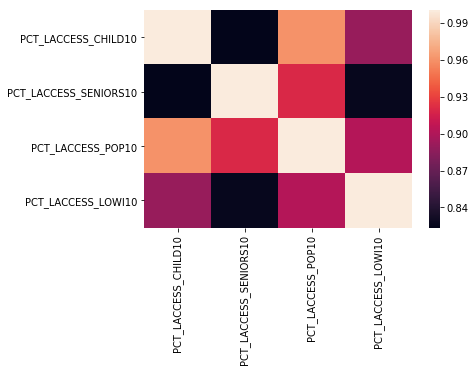

In [12]:
import seaborn as sns

highly_corr = corr_features(df)

sns.heatmap(df[highly_corr].corr().abs())
plt.show()

In [13]:
hc = df[highly_corr].corr().abs()

corr_cols = list(hc.columns)

corr_dict = {}
for col in corr_cols:
    print(col)
    print(list(hc.loc[(hc[col] > .9) & (hc[col] < 1)].index))

PCT_LACCESS_CHILD10
['PCT_LACCESS_POP10']
PCT_LACCESS_SENIORS10
['PCT_LACCESS_POP10']
PCT_LACCESS_POP10
['PCT_LACCESS_CHILD10', 'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_LOWI10']
PCT_LACCESS_LOWI10
['PCT_LACCESS_POP10']


We can see that several of the metrics for access and proximity to store are highly correlated. Because all of these are highly correlated with "Population, low access to store," we can drop the other three.

In [14]:
drop_corr = ['PCT_LACCESS_LOWI10', 'PCT_LACCESS_SENIORS10', 'PCT_LACCESS_CHILD10']
df = df[list(set(df.columns) - set(drop_corr))]

Finally, it's time to explore the target variable itself: Adult Diabetes in 2013.

We'll start with a histogram comparing diabetes rates in 2008 vs. diabetes rates in 2013.

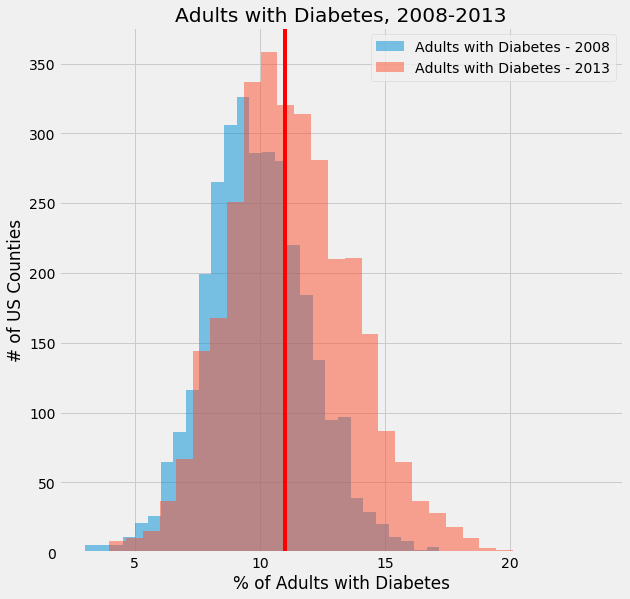

In [15]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(9,9))
plt.hist(data["PCT_DIABETES_ADULTS08"].dropna(axis=0), bins=30, alpha=0.5, label="Adults with Diabetes - 2008")
plt.hist(df["PCT_DIABETES_ADULTS13"], bins=30, alpha=0.5, label="Adults with Diabetes - 2013")
plt.title('Adults with Diabetes, 2008-2013')
plt.ylabel("# of US Counties")
plt.xlabel("% of Adults with Diabetes")
plt.legend()
plt.axvline(11.0, c='r')
plt.show()

As we suspected, diabetes rates seem to have risen overall.

Next, let's have a look at how these rates vary by state. Where are these high rates concentrated?

In [16]:
# create clean dataframe with geographic data
geo_data = data.loc[data["PCT_DIABETES_ADULTS13"].isna() == False, ['FIPS', 'State_x', "County_x"]]
geo_data = geo_data.iloc[:, [0,1,5]]
geo_data.columns = ['FIPS', 'State', 'County']

# make a copy of our master dataframe to merge with the geographic information on the FIPS column
df_fips = df.copy()
df_fips['FIPS'] = fips

# merge the two dataframes
geo_data = geo_data.merge(df_fips, on='FIPS')

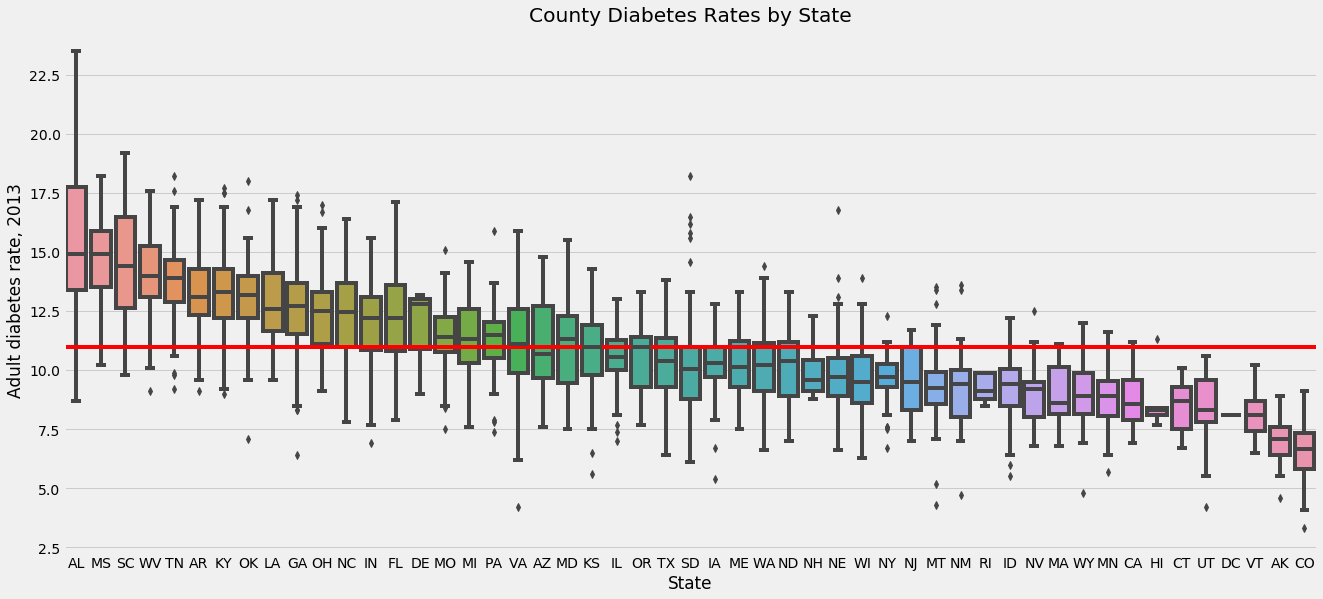

In [17]:
# group the diabetes rates by state, sort descending by mean rate
boxplot_order = geo_data.groupby('State').mean()
boxplot_order = boxplot_order.sort_values("PCT_DIABETES_ADULTS13", ascending=False)

# plot boxplots of county diabetes rates by state
fig, ax = plt.subplots(figsize=(20,9))
sns.boxplot(x='State', y='PCT_DIABETES_ADULTS13', data=geo_data, order=boxplot_order.index, ax=ax)
ax.set_title("County Diabetes Rates by State")
ax.set_ylabel("Adult diabetes rate, 2013")
ax.axhline(11.0, c='r')
plt.show()

Finally, let's set our target categories and use them to graph our actual diabetes belts in 2008 and 2013. We'll want to do this several times for plotting purposes, so we'll make a function.

In [18]:
def set_class(df, name='PCT_DIABETES_ADULTS13', targetname='CLASS', thresh=11.0):
    """ Converts a continuous feature into a binary feature.
    
    df: DataFrame
    name: String, title of continuous column
    targetname: String, name of new binary column
    thresh: float, point of separation for new binary feature
    """
    df[targetname] = df[name] >= thresh
    df[targetname] = df[targetname].map({True: 1, False: 0})
    df = df.drop(name, axis=1)
    return df

In [19]:
df = set_class(df)

Thanks to plotly and geopandas, we can plot choropleth maps to see where our diabetes belts actually are in 2008 and 2013. Let's do that.

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go
import geopandas
import shapefile
import shapely
from plotly.figure_factory._county_choropleth import create_choropleth
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [21]:
choro = data[['FIPS', 'PCT_DIABETES_ADULTS08', 'PCT_DIABETES_ADULTS13']]
choro.describe()

,FIPS,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13
count,3143.000000,3138.000000,3142.000000
mean,30390.411709,9.913257,11.236123
std,15164.717720,2.058922,2.485537
min,1001.000000,3.000000,3.300000
25%,18178.000000,8.500000,9.500000
50%,29177.000000,9.800000,11.100000
75%,45082.000000,11.300000,12.900000
max,56045.000000,18.200000,23.500000


In [22]:
choro = set_class(choro, targetname='DIABETES_13')
choro = set_class(choro, name='PCT_DIABETES_ADULTS08', targetname='DIABETES_08')

In [ ]:
fips = choro['FIPS']
values = choro['DIABETES_08'].map({1: "11% or Above", 0: "Below 11%"})

fig = create_choropleth(fips=fips, 
                        values=values, 
                        colorscale=["#fc8d59", "#91bfdb"], 
                        legend_title='Diabetes Belt - 2008', 
                        state_outline={'width': 1, 'color': "#000"})
iplot(fig)

/home/calre/anaconda2/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [ ]:
fips = choro['FIPS']
values = choro['DIABETES_13'].map({1: "11% or Above", 0: "Below 11%"})

fig = create_choropleth(fips=fips, 
                        values=values, 
                        colorscale=["#fc8d59", "#91bfdb"], 
                        legend_title='Diabetes Belt - 2013', 
                        state_outline={'width': 1, 'color': "#000"})
iplot(fig)

What looked like a belt in 2008 has expanded considerably in 2013.

# Feature Selection

We still have too many features for it to be worth exploring every single one in great detail. We'll use a Random Forest to rank feature importance by Gini index to narrow things down.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [ ]:
X = df.copy()
y = X.pop('CLASS')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
feat_labels = list(X.columns)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Create summary DataFrame
results = pd.DataFrame({'Features': feat_labels, "Gini": clf.feature_importances_})

In [ ]:
# Sort DataFrame by Gini Index, descending
results = results.sort_values(by='Gini', ascending=False)
print(results)

titles = list(results['Features'])

Fantastic! Already we can see some truly crucial features have floated to the top.

In order to determine which ones to remove, we'll use a backward selection algorithm.

In [ ]:
def backward(X, y, f_list):
    """ Takes a dataframe of features, a target, and a list of feature names sorted by Gini index.
        Returns a summary DataFrame with accuracy impact of removing less important features.
    
    X: DataFrame, features
    y: DataFrame, target
    f_list: array, feature names sorted by Gini index, descending
    """
    
    f_list.append('NONE')
    feature_counts = []
    popped_features = []
    test_score_list = []

    while len(f_list) > 1:
        dropped = f_list.pop()
        feature_count = len(f_list)
        
        X = X.loc[:,f_list]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
        clf.fit(X_train, y_train)
        
        y_pred_test = clf.predict(X_test)
        test_score = accuracy_score(y_test, y_pred_test)
        
        feature_counts.append(feature_count)
        popped_features.append(dropped)
        test_score_list.append(test_score)
        
    summary = pd.DataFrame({"# Features": feature_counts,
                            "Dropped Feature": popped_features,
                            "Test Accuracy": test_score_list})
    return summary

In [ ]:
summary = backward(X, y, titles)
summary

In [ ]:
plt.plot(summary['# Features'], summary['Test Accuracy'])
plt.title("# of Features vs. Accuracy")
plt.xlabel("Features")
plt.ylabel("Accuracy")

It appears that the first seven features are the most impactful for our initial model. Let's isolate those and explore them.

In [ ]:
final = list(results['Features'])[:7]
final

In [ ]:
decode(final)

Examining these features, it appears that we can separate them into four major categories. Let's do that!

In [ ]:
obesity = ['PCT_OBESE_ADULTS13']
access = ['PCT_LACCESS_HHNV10', 'SNAPSPTH12']
food_assist = ['PCT_SNAP12', 'PCT_SBP09']
race_age = ['PCT_HISP10', 'PCT_65OLDER10']

Now, we'll explore them visually in relation to adult diabetes rate. Let's make a function for that.

In [ ]:
def boxplotter(features, rows, cols, title):
    """Creates a grid of boxplots, delineated by diabetes rate.
    
    features: array, the features to be plotted
    rows: int, number of rows in grid
    cols: int, number of cols in grid
    title: String, title of plot
    
    """
    
    ylabels = decode(features)
    ylabels = list(ylabels["Variable Name"])
    fig, axes = plt.subplots(rows, cols, squeeze=False, figsize = (7*cols, 6*rows))
    fig.suptitle(title)
    fig.subplots_adjust(top=0.90, wspace=0.3)
    
    for i, name in enumerate(features):
        row = i // 3        
        col = i % 3
        if len(features) == 1:
            ax = axes[0,0]
        else:
            ax = axes[row,col]
        sns.boxplot(x='CLASS', y=name, data=df, showfliers=False, ax=ax)
        axes[row,col].set_xticklabels(["Below 11%", "11% or Greater"])
        axes[row,col].set_xlabel("Diabetes Rate")
        axes[row,col].set_ylabel(ylabels[i].split('(')[0])
    

In [ ]:
boxplotter(obesity, 1, 1, 'Obesity - No Belt vs. Belt')

Here, the relationship is clear. The median county diabetes rate in the Belt is at least 5% greater than outside of it.

In [ ]:
boxplotter(access, 1, 2, 'Food Access - No Belt vs. Belt')

Clearly, household access to store is an important factor, with **lower access overall in the belt.** SNAP-authorized stores may be thought of here as a **proxy for poverty**, as it is likely that there are more such stores in impoverished areas.

In [ ]:
boxplotter(food_assist, 1, 2, 'Food Assistance - No Belt vs. Belt')

Again, these measures are probably best thought of as **proxies for poverty,** though it might take more domain knowledge to really know what is going on. Still, rates seem to be generally higher on the belt than off of it.

In [ ]:
boxplotter(race_age, 1, 2, "Race & Age - No Belt vs. Belt")

There are some well-documented relationships between diabetes and people from certain ethnic backgrounds. Here, larger Hispanic populations are better represented off of the belt!

Meanwhile, older populations are slightly better represented on average on the belt.

# Model

Now that we have cleaned our data and selected and explored our features, it is time to select a machine learning model. In order to do this, we'll build a pipeline to test four popular algorithms for classification:

1. Logistic Regression
2. Naive Bayes
3. Support Vector Machines
4. Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
print(final)

In [ ]:
# obtain a final clean dataframe with just our selected features
final_df = clean(data)
fips = final_df.pop('FIPS')
final_df = set_class(final_df)
y = final_df.pop('CLASS')
X = final_df[final]

In [ ]:
# instantiate our models
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Naive Bayes', GaussianNB()),
    ('SVM', SVC(gamma='scale')),
    ('Random Forest', RandomForestClassifier(n_estimators=1000, n_jobs=-1))
]

In [ ]:
results_accuracy = []
results_recall = []
names = []

# perform kfold validation on our data, applying each model 10 times and returning the means of the accuracy and recall scores
for name, model in models:
    names.append(name)
    
    kfold = model_selection.KFold(n_splits=10, random_state=1)
    cv_results_acc = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results_accuracy.append(cv_results_acc)

    cv_results_rec = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='recall')
    results_recall.append(cv_results_rec)
    
    msg = "{}: Mean Accuracy: {}; Mean Recall: {}".format(name, np.mean(results_accuracy[-1]), np.mean(results_recall[-1]))
    print(msg)

In [ ]:
# plot boxplots of the returned mean scores
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 7))
fig.suptitle('Algorithm Comparison')
ax1.boxplot(results_accuracy)
ax1.set_title('Accuracy')
ax1.set_xticklabels(names, rotation=45)
ax1.set_ylim(0.2,1.0)
ax1.set_ylabel("% Accuracy")
ax2.boxplot(results_recall)
ax2.set_xticklabels(names, rotation=45)
ax2.set_title('Recall')
ax2.set_ylim(0.2,1.0)
ax2.set_ylabel("% Recall")
plt.show()

This is very interesting! All four models performed very well. Naive Bayes seems more likely than the others to identify a county as on the belt than the others, but is still within the ballpark of accuracy.

The fact that logistic regression performs as well as it does indicates to me that the features contribute to the probability in an essentially linear fashion. Because it is a fast algorithm, accurate in this case, and robust against overfitting, we will select it for this case. Further exploration and tuning might change this determination.

# Interpret

At last, we'll have a look at the confusion matrix, and predict our final 2013 Diabetes Belt.

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)

lr.predict(X)

y_pred = cross_val_predict(lr, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)

In [ ]:
conf_mat

In [ ]:
import itertools

# map an image onto the confusion matrix
plt.imshow(conf_mat,  cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

thresh = conf_mat.max() / 2

for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, conf_mat[i, j],
                 horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

plt.colorbar()
plt.grid(False)

This model seems well tuned for accuracy, with a similar number of false positives and false negatives.

In [ ]:
geo = ['FIPS'] + final
geo_df = clean(data)
geo_df = geo_df[geo]
geo_fips = geo_df.pop('FIPS')

map_pred = pd.Series(lr.predict(geo_df))

fips = geo_fips
values = map_pred.map({1: "11% or Above", 0: "Below 11%"})

fig = create_choropleth(fips=fips, 
                        values=values, 
                        colorscale=["#fc8d59", "#91bfdb"], 
                        legend_title='Predicted Diabetes Belt - 2013', 
                        state_outline={'width': 1, 'color': "#000"})
iplot(fig)

## Conclusion

Given the wealth of data in the USDA's Food Environment Atlas, it is possible to construct a classifier that will determine whether a US county is a member of the CDC's Diabetes Belt with **~80% accuracy**.

Top features appear to be **obesity, food access, food assistance, and race/age**. Some of these may be proxies for the effect of **poverty**, rather than causes in of themselves.

We received excellent performance from all classifiers trialed, and ended up picking **logistic regression**, which is fast, accurate in this case, and robust against overfitting.

I feel confident that with more data and finer tuning, even more accurate models may be built. That is another project! Thanks for reading.